# 🌲 Semantic Segmentation of Tree Trunks in Broadleaf Forest Imagery

## UNet-Based Deep Learning Approach

### 📋 Overview
- **Dataset**: Broadleaf Forest RGB Images
- **Task**: Binary Semantic Segmentation (Tree Trunk vs Background)
- **Model**: UNet (Encoder-Decoder with Skip Connections)
- **Framework**: PyTorch

### 📌 Notebook Structure
1. Environment Setup & Dependencies
2. Dataset Preparation & Loading
3. UNet Model Architecture
4. Training Pipeline
5. Evaluation Metrics
6. Visualization & Results
7. Discussion & Analysis

## 1️⃣ Environment Setup and Dependencies

Mount Google Drive and install all required libraries for deep learning, data processing, and visualization. Set random seeds for reproducibility.

In [3]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Install required libraries
!pip install -q torchsummary tqdm
print("✅ Libraries installed successfully!")

✅ Libraries installed successfully!


In [5]:
# Import all required libraries
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary

# Scikit-learn for data splitting
from sklearn.model_selection import train_test_split

# Memory management for Colab
import gc

def clear_memory():
    """Clear GPU and CPU memory."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Set random seeds for reproducibility
def set_all_seeds(seed=42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 42
set_all_seeds(SEED)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"🎲 Random seed set to: {SEED}")

🖥️ Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB
🎲 Random seed set to: 42


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2️⃣ Dataset Configuration and Path Setup

Define the base paths for accessing the broadleaf forest dataset from Google Drive.

In [7]:
# ============================================================================
# Dataset Configuration
# ============================================================================

# Base path to the broadleaf dataset on Google Drive
BASE_PATH = '/content/drive/MyDrive/data'

# Paths to RGB images and semantic segmentation masks
RGB_DIR = os.path.join(BASE_PATH, 'rgb')
MASK_DIR = os.path.join(BASE_PATH, 'semantic_segmentation')

# Target image size for processing (Height, Width)
# Reduced from 256 to 128 for Colab memory efficiency
IMAGE_SIZE = (128, 128)

# Training hyperparameters - optimized for Colab
BATCH_SIZE = 4  # Reduced for memory
NUM_EPOCHS = 20  # Slightly reduced
LEARNING_RATE = 1e-4
NUM_WORKERS = 0  # Set to 0 for Colab compatibility

# Print configuration
print("=" * 60)
print("📁 DATASET CONFIGURATION")
print("=" * 60)
print(f"Base path:     {BASE_PATH}")
print(f"RGB directory: {RGB_DIR}")
print(f"Mask directory:{MASK_DIR}")
print(f"Image size:    {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}")
print("=" * 60)
print("🔧 TRAINING HYPERPARAMETERS")
print("=" * 60)
print(f"Batch size:    {BATCH_SIZE}")
print(f"Epochs:        {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print("=" * 60)

# Verify directories exist
if os.path.exists(RGB_DIR):
    print(f"✅ RGB directory found")
else:
    print(f"❌ RGB directory NOT found at {RGB_DIR}")

if os.path.exists(MASK_DIR):
    print(f"✅ Mask directory found")
else:
    print(f"❌ Mask directory NOT found at {MASK_DIR}")

📁 DATASET CONFIGURATION
Base path:     /content/drive/MyDrive/data
RGB directory: /content/drive/MyDrive/data/rgb
Mask directory:/content/drive/MyDrive/data/semantic_segmentation
Image size:    128x128
🔧 TRAINING HYPERPARAMETERS
Batch size:    4
Epochs:        20
Learning rate: 0.0001
✅ RGB directory found
✅ Mask directory found


## 3️⃣ Dataset Loading and RGB-Mask Matching

Load all RGB images and their corresponding semantic segmentation masks. Match files by their base filename and validate the pairs.

In [8]:
def get_image_files(directory, extensions=['png', 'jpg', 'jpeg']):
    """Get all image files from a directory with specified extensions."""
    files = []
    for ext in extensions:
        files.extend(glob.glob(os.path.join(directory, f'*.{ext}')))
        files.extend(glob.glob(os.path.join(directory, f'*.{ext.upper()}')))
    return sorted(files)


def match_rgb_mask_pairs(rgb_dir, mask_dir):
    """Match RGB images with their corresponding semantic segmentation masks."""
    rgb_files = get_image_files(rgb_dir)
    mask_files = get_image_files(mask_dir)

    print(f"Found {len(rgb_files)} RGB images")
    print(f"Found {len(mask_files)} mask images")

    # Create a dictionary for quick lookup of mask files by base name
    mask_dict = {}
    for mask_path in mask_files:
        base_name = os.path.splitext(os.path.basename(mask_path))[0]
        mask_dict[base_name] = mask_path

    # Match RGB files with masks
    matched_pairs = []
    unmatched = []

    for rgb_path in rgb_files:
        base_name = os.path.splitext(os.path.basename(rgb_path))[0]
        if base_name in mask_dict:
            matched_pairs.append((rgb_path, mask_dict[base_name]))
        else:
            unmatched.append(base_name)

    if unmatched and len(unmatched) <= 5:
        print(f"⚠️ {len(unmatched)} RGB images without matching masks: {unmatched}")
    elif unmatched:
        print(f"⚠️ {len(unmatched)} RGB images without matching masks")

    return matched_pairs


# Match RGB images with masks
print("=" * 60)
print("📂 LOADING DATASET")
print("=" * 60)

image_mask_pairs = match_rgb_mask_pairs(RGB_DIR, MASK_DIR)

print(f"\n✅ Successfully matched {len(image_mask_pairs)} RGB-mask pairs")

# Display some examples
if image_mask_pairs:
    print("\n📋 Sample matched pairs:")
    for i, (rgb, mask) in enumerate(image_mask_pairs[:5]):
        print(f"   {i+1}. RGB: {os.path.basename(rgb)}")
        print(f"      Mask: {os.path.basename(mask)}")

📂 LOADING DATASET
Found 2705 RGB images
Found 3314 mask images

✅ Successfully matched 2705 RGB-mask pairs

📋 Sample matched pairs:
   1. RGB: Tree0_1720149451.png
      Mask: Tree0_1720149451.png
   2. RGB: Tree1001_1720187095.png
      Mask: Tree1001_1720187095.png
   3. RGB: Tree1003_1720158833.png
      Mask: Tree1003_1720158833.png
   4. RGB: Tree1003_1720263501.png
      Mask: Tree1003_1720263501.png
   5. RGB: Tree1004_1720158415.png
      Mask: Tree1004_1720158415.png


## 4️⃣ Custom PyTorch Dataset Class

Implement a custom Dataset class for loading, preprocessing, and augmenting the broadleaf forest images and masks.

In [9]:
class BroadleafDataset(Dataset):
    """
    Custom PyTorch Dataset for Broadleaf Forest Semantic Segmentation.

    Handles loading RGB images and masks, resizing, ImageNet normalization,
    mask binarization, and optional data augmentation.
    """

    # ImageNet normalization statistics
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    def __init__(self, image_mask_pairs, target_size=(256, 256), augment=False):
        self.image_mask_pairs = image_mask_pairs
        self.target_size = target_size
        self.augment = augment

        # Image transformation: Convert to tensor and normalize
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD)
        ])

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        rgb_path, mask_path = self.image_mask_pairs[idx]

        # Load RGB image
        image = Image.open(rgb_path).convert('RGB')
        # Load mask as grayscale
        mask = Image.open(mask_path).convert('L')

        # Resize image (bilinear) and mask (nearest neighbor)
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # Data augmentation (if enabled)
        if self.augment:
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
                mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        # Apply image transformations
        image = self.image_transform(image)

        # Convert mask to binary tensor
        mask = np.array(mask, dtype=np.float32)
        mask = (mask > 0).astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask

    def get_original_image(self, idx):
        """Get the original (non-normalized) image for visualization."""
        rgb_path, _ = self.image_mask_pairs[idx]
        image = Image.open(rgb_path).convert('RGB')
        image = image.resize(self.target_size, Image.BILINEAR)
        return np.array(image)


print("✅ BroadleafDataset class defined successfully")

✅ BroadleafDataset class defined successfully


## 5️⃣ Data Splitting and DataLoader Creation

Split the dataset into training (70%), validation (15%), and test (15%) sets. Create DataLoader instances for efficient batch processing.

In [10]:
# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# First split: separate training from the rest
train_pairs, temp_pairs = train_test_split(
    image_mask_pairs,
    train_size=TRAIN_RATIO,
    random_state=SEED
)

# Second split: separate validation and test from temp
val_pairs, test_pairs = train_test_split(
    temp_pairs,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    random_state=SEED
)

print("=" * 60)
print("📊 DATA SPLIT SUMMARY")
print("=" * 60)
print(f"Total samples:      {len(image_mask_pairs)}")
print(f"Training samples:   {len(train_pairs)} ({len(train_pairs)/len(image_mask_pairs)*100:.1f}%)")
print(f"Validation samples: {len(val_pairs)} ({len(val_pairs)/len(image_mask_pairs)*100:.1f}%)")
print(f"Test samples:       {len(test_pairs)} ({len(test_pairs)/len(image_mask_pairs)*100:.1f}%)")
print("=" * 60)

# Create Dataset instances
train_dataset = BroadleafDataset(train_pairs, target_size=IMAGE_SIZE, augment=True)
val_dataset = BroadleafDataset(val_pairs, target_size=IMAGE_SIZE, augment=False)
test_dataset = BroadleafDataset(test_pairs, target_size=IMAGE_SIZE, augment=False)

# Create DataLoaders - optimized for Colab
use_pin_memory = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=use_pin_memory,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=use_pin_memory
)

print(f"\n✅ DataLoaders created:")
print(f"   Training batches:   {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches:       {len(test_loader)}")

📊 DATA SPLIT SUMMARY
Total samples:      2705
Training samples:   1893 (70.0%)
Validation samples: 406 (15.0%)
Test samples:       406 (15.0%)

✅ DataLoaders created:
   Training batches:   473
   Validation batches: 102
   Test batches:       102


## 6️⃣ Dataset Statistics and Class Imbalance Analysis

Analyze the class distribution in the training set to understand the imbalance between tree trunk pixels (foreground) and background pixels. This is crucial for selecting appropriate loss functions.

📈 CLASS DISTRIBUTION ANALYSIS
Analyzing 50 samples from Training Set...


Analyzing: 100%|██████████| 50/50 [01:55<00:00,  2.30s/it]



📊 Training Set Statistics:
   Total pixels analyzed: 819,200
   Foreground (trunk): 188,478 (23.01%)
   Background: 630,722 (76.99%)
   Imbalance ratio: 1:3.3


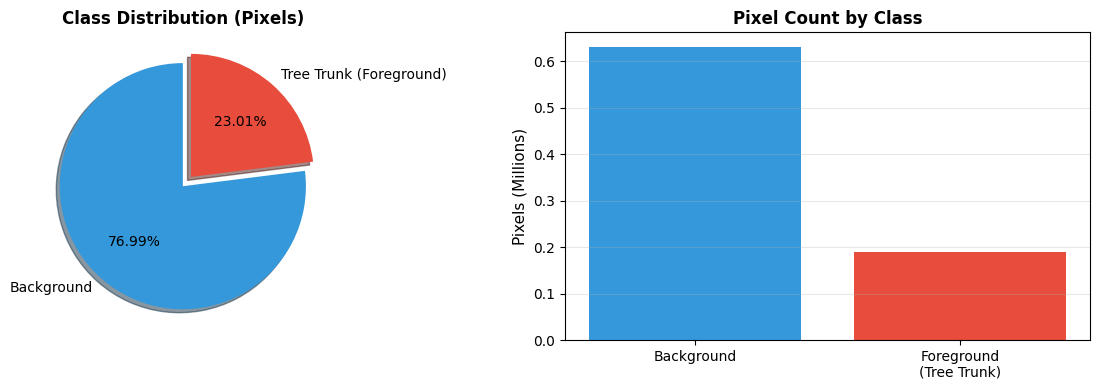


⚠️ CLASS IMBALANCE DETECTED:
   This justifies using Dice Loss or BCE+Dice combined loss to handle imbalance.


In [11]:
def analyze_class_distribution(dataset, dataset_name="Dataset", num_samples=None):
    """Analyze the class distribution (foreground vs background) in the dataset."""
    total_foreground = 0
    total_background = 0
    total_pixels = 0

    n_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    print(f"Analyzing {n_samples} samples from {dataset_name}...")

    for i in tqdm(range(n_samples), desc="Analyzing"):
        _, mask = dataset[i]
        mask_np = mask.numpy().squeeze()
        foreground = mask_np.sum()
        background = mask_np.size - foreground
        total_foreground += foreground
        total_background += background
        total_pixels += mask_np.size

    fg_percent = (total_foreground / total_pixels) * 100
    bg_percent = (total_background / total_pixels) * 100
    imbalance_ratio = total_background / total_foreground if total_foreground > 0 else float('inf')

    return {
        'foreground_pixels': int(total_foreground),
        'background_pixels': int(total_background),
        'total_pixels': int(total_pixels),
        'foreground_percent': fg_percent,
        'background_percent': bg_percent,
        'imbalance_ratio': imbalance_ratio
    }


# Analyze class distribution (sample only for efficiency)
print("=" * 60)
print("📈 CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)

max_samples_to_analyze = min(50, len(train_dataset))
train_stats = analyze_class_distribution(train_dataset, "Training Set", num_samples=max_samples_to_analyze)

print(f"\n📊 Training Set Statistics:")
print(f"   Total pixels analyzed: {train_stats['total_pixels']:,}")
print(f"   Foreground (trunk): {train_stats['foreground_pixels']:,} ({train_stats['foreground_percent']:.2f}%)")
print(f"   Background: {train_stats['background_pixels']:,} ({train_stats['background_percent']:.2f}%)")
print(f"   Imbalance ratio: 1:{train_stats['imbalance_ratio']:.1f}")

# Visualize class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

labels = ['Background', 'Tree Trunk (Foreground)']
sizes = [train_stats['background_percent'], train_stats['foreground_percent']]
colors = ['#3498db', '#e74c3c']
explode = (0, 0.1)

ax[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%',
         shadow=True, startangle=90)
ax[0].set_title('Class Distribution (Pixels)', fontsize=12, fontweight='bold')

ax[1].bar(['Background', 'Foreground\n(Tree Trunk)'],
         [train_stats['background_pixels']/1e6, train_stats['foreground_pixels']/1e6],
         color=colors)
ax[1].set_ylabel('Pixels (Millions)', fontsize=11)
ax[1].set_title('Pixel Count by Class', fontsize=12, fontweight='bold')
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ CLASS IMBALANCE DETECTED:")
print(f"   This justifies using Dice Loss or BCE+Dice combined loss to handle imbalance.")

## 7️⃣ Sample Visualization with RGB-Mask Overlay

Visualize random samples from the dataset to verify correct data loading and preprocessing.

🖼️ SAMPLE VISUALIZATION


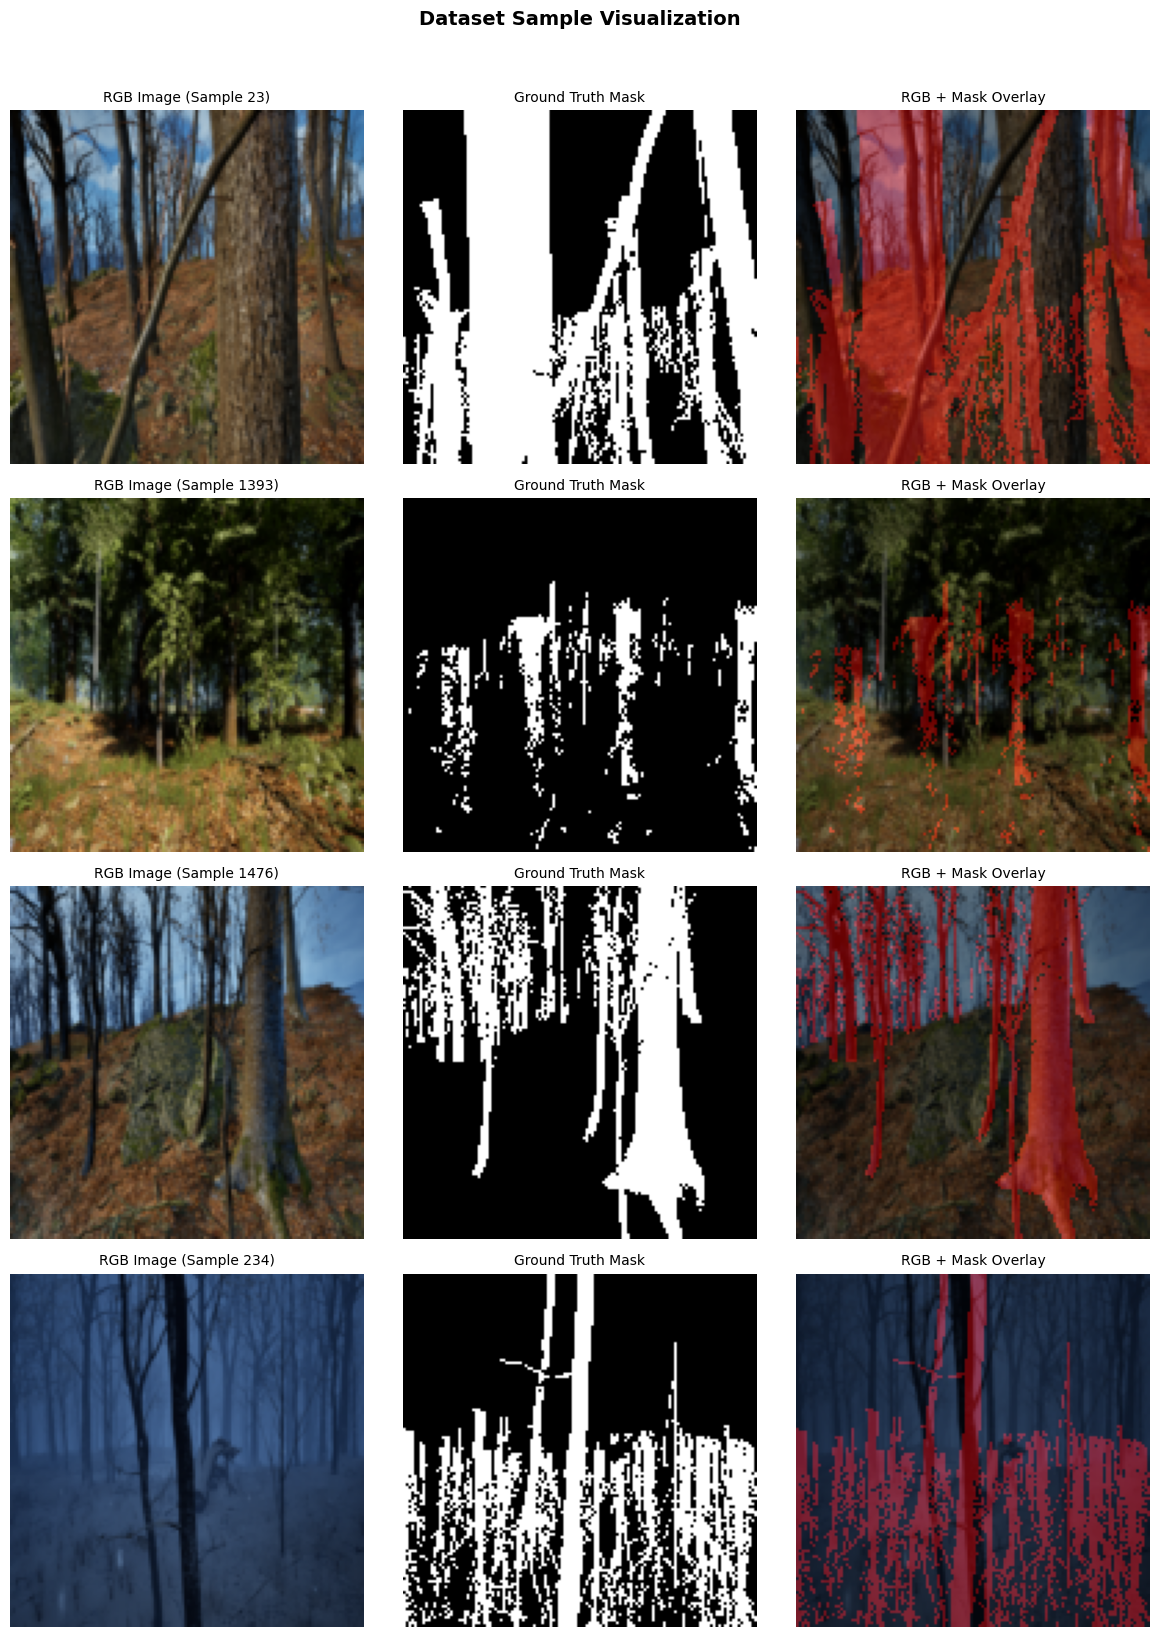

In [12]:
def visualize_samples(dataset, num_samples=4, random_samples=True):
    """Visualize RGB images with their corresponding masks."""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    if random_samples:
        indices = random.sample(range(len(dataset)), num_samples)
    else:
        indices = range(num_samples)

    for row, idx in enumerate(indices):
        original_img = dataset.get_original_image(idx)
        _, mask = dataset[idx]
        mask_np = mask.numpy().squeeze()

        axes[row, 0].imshow(original_img)
        axes[row, 0].set_title(f'RGB Image (Sample {idx})', fontsize=10)
        axes[row, 0].axis('off')

        axes[row, 1].imshow(mask_np, cmap='gray')
        axes[row, 1].set_title('Ground Truth Mask', fontsize=10)
        axes[row, 1].axis('off')

        overlay = original_img.copy()
        mask_rgb = np.zeros_like(original_img)
        mask_rgb[:, :, 0] = mask_np * 255
        overlay = (0.6 * overlay + 0.4 * mask_rgb).astype(np.uint8)

        axes[row, 2].imshow(overlay)
        axes[row, 2].set_title('RGB + Mask Overlay', fontsize=10)
        axes[row, 2].axis('off')

    plt.suptitle('Dataset Sample Visualization', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


print("=" * 60)
print("🖼️ SAMPLE VISUALIZATION")
print("=" * 60)
visualize_samples(train_dataset, num_samples=4, random_samples=True)

---

## 8️⃣ UNet Model Architecture Implementation

Implement the UNet architecture from scratch with:
- **Encoder (Contracting Path)**: Series of Conv → BatchNorm → ReLU → MaxPool blocks
- **Decoder (Expanding Path)**: Series of TransposeConv → Concatenate → Conv blocks  
- **Skip Connections**: Connect encoder features to decoder for spatial detail preservation
- **Final Layer**: 1×1 convolution for pixel-wise classification

### Why UNet?
- Designed specifically for biomedical/semantic segmentation tasks
- Skip connections preserve spatial information lost during downsampling
- Symmetric encoder-decoder enables precise localization
- Efficient with limited training data

In [13]:
class ConvBlock(nn.Module):
    """Double convolution block: (Conv2d → BatchNorm → ReLU) × 2"""
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class EncoderBlock(nn.Module):
    """Encoder block: ConvBlock followed by MaxPool2d for downsampling."""
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        features = self.conv(x)
        pooled = self.pool(features)
        return features, pooled


class DecoderBlock(nn.Module):
    """Decoder block: Upsample → Concatenate with skip features → ConvBlock"""
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels // 2 + skip_channels, out_channels)

    def forward(self, x, skip_features):
        x = self.upsample(x)
        if x.shape != skip_features.shape:
            x = F.interpolate(x, size=skip_features.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip_features], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    """
    UNet Architecture for Semantic Segmentation (Lite version for Colab)

    - Encoder: 4 encoding blocks with increasing channels (32→64→128→256)
    - Bottleneck: 512 channels at the deepest level
    - Decoder: 4 decoding blocks with decreasing channels
    - Output: 1×1 conv for binary segmentation
    """
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()

        # Encoder
        prev_channels = in_channels
        for feature in features:
            self.encoders.append(EncoderBlock(prev_channels, feature))
            prev_channels = feature

        # Bottleneck
        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)

        # Decoder
        reversed_features = list(reversed(features))
        for i, feature in enumerate(reversed_features):
            in_ch = features[-1] * 2 if i == 0 else reversed_features[i-1]
            self.decoders.append(DecoderBlock(in_ch, feature, feature))

        # Output layer
        self.output = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for encoder in self.encoders:
            features, x = encoder(x)
            skip_connections.append(features)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i, decoder in enumerate(self.decoders):
            x = decoder(x, skip_connections[i])

        return self.output(x)


# Create model instance
model = UNet(in_channels=3, out_channels=1).to(device)
print("✅ UNet model created successfully!")

✅ UNet model created successfully!


### Model Summary and Parameter Count

Display the model architecture summary including layer shapes, parameter counts, and memory requirements.

In [14]:
print("=" * 60)
print("🏗️ UNET MODEL ARCHITECTURE SUMMARY")
print("=" * 60)

try:
    summary(model, input_size=(3, IMAGE_SIZE[0], IMAGE_SIZE[1]), device=str(device))
except Exception as e:
    print(f"Note: torchsummary error: {e}")

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parameter Statistics:")
print(f"   Total parameters:     {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Non-trainable:        {total_params - trainable_params:,}")

# Verify input/output dimensions
test_input = torch.randn(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)
test_output = model(test_input)
print(f"\n📐 Input/Output Dimensions:")
print(f"   Input shape:  {test_input.shape}")
print(f"   Output shape: {test_output.shape}")

🏗️ UNET MODEL ARCHITECTURE SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,216
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         ConvBlock-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
      EncoderBlock-9  [[-1, 32, 128, 128], [-1, 32, 64, 64]]               0
           Conv2d-10           [-1, 64, 64, 64]          18,432
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]        

---

## 9️⃣ Loss Functions: BCE and Dice Loss

For semantic segmentation with class imbalance, we use a combination of:
1. **Binary Cross-Entropy (BCE)**: Pixel-wise classification loss
2. **Dice Loss**: Overlap-based loss that handles class imbalance well

### Why BCE + Dice Combined?
- **BCE** provides stable gradients for all pixels
- **Dice Loss** focuses on overlap, naturally handling class imbalance
- **Combined** leverages strengths of both approaches

In [15]:
class DiceLoss(nn.Module):
    """Dice Loss for binary segmentation."""
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        intersection = (predictions * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (
            predictions.sum() + targets.sum() + self.smooth
        )
        return 1 - dice_coeff


class BCEDiceLoss(nn.Module):
    """Combined Binary Cross-Entropy and Dice Loss."""
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


# Initialize loss function
criterion = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)
print("✅ Loss function: BCE + Dice Loss (0.5 each)")
print("   This combination is optimal for handling class imbalance in segmentation tasks.")

✅ Loss function: BCE + Dice Loss (0.5 each)
   This combination is optimal for handling class imbalance in segmentation tasks.


## 🔟 Evaluation Metrics Implementation

Implement comprehensive evaluation metrics for semantic segmentation:
- **Pixel Accuracy**: Overall correct pixel percentage
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)  
- **F1-Score**: Harmonic mean of Precision and Recall
- **IoU (Jaccard Index)**: Intersection / Union of prediction and ground truth
- **Dice Coefficient**: 2× Intersection / (Prediction + Ground Truth)

In [16]:
class SegmentationMetrics:
    """Comprehensive evaluation metrics for binary semantic segmentation."""

    def __init__(self, threshold=0.5, epsilon=1e-7):
        self.threshold = threshold
        self.epsilon = epsilon

    def _get_binary_predictions(self, predictions, targets):
        if predictions.min() < 0 or predictions.max() > 1:
            predictions = torch.sigmoid(predictions)
        predictions = (predictions > self.threshold).float()
        return predictions, targets

    def pixel_accuracy(self, predictions, targets):
        predictions, targets = self._get_binary_predictions(predictions, targets)
        correct = (predictions == targets).float().sum()
        total = targets.numel()
        return (correct / total).item()

    def precision(self, predictions, targets):
        predictions, targets = self._get_binary_predictions(predictions, targets)
        true_positives = (predictions * targets).sum()
        predicted_positives = predictions.sum()
        return (true_positives / (predicted_positives + self.epsilon)).item()

    def recall(self, predictions, targets):
        predictions, targets = self._get_binary_predictions(predictions, targets)
        true_positives = (predictions * targets).sum()
        actual_positives = targets.sum()
        return (true_positives / (actual_positives + self.epsilon)).item()

    def f1_score(self, predictions, targets):
        prec = self.precision(predictions, targets)
        rec = self.recall(predictions, targets)
        return (2 * prec * rec) / (prec + rec + self.epsilon)

    def iou(self, predictions, targets):
        predictions, targets = self._get_binary_predictions(predictions, targets)
        intersection = (predictions * targets).sum()
        union = predictions.sum() + targets.sum() - intersection
        return (intersection / (union + self.epsilon)).item()

    def dice_coefficient(self, predictions, targets):
        predictions, targets = self._get_binary_predictions(predictions, targets)
        intersection = (predictions * targets).sum()
        return ((2. * intersection) / (predictions.sum() + targets.sum() + self.epsilon)).item()

    def compute_all(self, predictions, targets):
        return {
            'pixel_accuracy': self.pixel_accuracy(predictions, targets),
            'precision': self.precision(predictions, targets),
            'recall': self.recall(predictions, targets),
            'f1_score': self.f1_score(predictions, targets),
            'iou': self.iou(predictions, targets),
            'dice': self.dice_coefficient(predictions, targets)
        }


metrics_calculator = SegmentationMetrics(threshold=0.5)

print("✅ Evaluation metrics defined:")
print("   • Pixel Accuracy - Overall correctness")
print("   • Precision - False positive control")
print("   • Recall - False negative control")
print("   • F1-Score - Balance of precision/recall")
print("   • IoU (Jaccard) - Overlap measure")
print("   • Dice Coefficient - Segmentation overlap")

✅ Evaluation metrics defined:
   • Pixel Accuracy - Overall correctness
   • Precision - False positive control
   • Recall - False negative control
   • F1-Score - Balance of precision/recall
   • IoU (Jaccard) - Overlap measure
   • Dice Coefficient - Segmentation overlap


---

## 1️⃣1️⃣ Training Pipeline Setup

Set up the complete training pipeline with:
- Adam optimizer with learning rate scheduling
- Training and validation loops with progress tracking
- Model checkpointing for best validation performance

In [17]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1} [Train]', leave=False, ncols=100)

    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    return running_loss / len(train_loader)


def validate(model, val_loader, criterion, device, metrics_calc):
    """Validate the model on the validation set."""
    model.eval()
    running_loss = 0.0

    all_metrics = {
        'pixel_accuracy': [], 'precision': [], 'recall': [],
        'f1_score': [], 'iou': [], 'dice': []
    }

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Validating', leave=False):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            batch_metrics = metrics_calc.compute_all(outputs, masks)
            for key in all_metrics:
                all_metrics[key].append(batch_metrics[key])

    avg_loss = running_loss / len(val_loader)
    avg_metrics = {k: float(np.mean(v)) for k, v in all_metrics.items()}

    return avg_loss, avg_metrics


# Optimizer & Scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("✅ Training pipeline configured:")
print(f"   Optimizer : Adam (lr={LEARNING_RATE})")
print("   Scheduler : ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"   Device    : {device}")

✅ Training pipeline configured:
   Optimizer : Adam (lr=0.0001)
   Scheduler : ReduceLROnPlateau (factor=0.5, patience=3)
   Device    : cuda


### Main Training Loop

Execute the full training process with validation after each epoch. Track losses and save the best model.

In [18]:
# Storage for training history
history = {'train_loss': [], 'val_loss': [], 'val_iou': [], 'val_dice': []}

# Best model tracking
best_val_loss = float('inf')
best_model_path = '/content/drive/MyDrive/broadleaf/best_unet_model.pth'

print("=" * 60)
print("🚀 STARTING TRAINING")
print("=" * 60)
print(f"Training for {NUM_EPOCHS} epochs...")
print(f"Best model will be saved to: {best_model_path}")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_metrics = validate(model, val_loader, criterion, device, metrics_calculator)

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_metrics['iou'])
    history['val_dice'].append(val_metrics['dice'])

    # Clear memory after each epoch
    clear_memory()

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val IoU:    {val_metrics['iou']:.4f}")
    print(f"  Val Dice:   {val_metrics['dice']:.4f}")
    print(f"  Val F1:     {val_metrics['f1_score']:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_metrics': val_metrics
        }, best_model_path)
        print(f"  ✅ New best model saved! (Val Loss: {val_loss:.4f})")

print("\n" + "=" * 60)
print("✅ TRAINING COMPLETED!")
print("=" * 60)
print(f"Best validation loss: {best_val_loss:.4f}")

🚀 STARTING TRAINING
Training for 20 epochs...
Best model will be saved to: /content/drive/MyDrive/broadleaf/best_unet_model.pth



Epoch 1/20
  Train Loss: 0.4798
  Val Loss:   0.3987
  Val IoU:    0.5791
  Val Dice:   0.7317
  Val F1:     0.7317


RuntimeError: Parent directory /content/drive/MyDrive/broadleaf does not exist.

## 1️⃣2️⃣ Training Visualization - Loss Curves

Plot the training and validation loss curves to analyze model convergence and detect potential overfitting.

In [ ]:
def plot_training_history(history):
    """Plot training and validation loss curves along with metrics."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Training vs Validation Loss', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history['val_iou'], 'g-', label='Validation IoU', linewidth=2, marker='o')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('IoU', fontsize=11)
    axes[1].set_title('Validation IoU Progress', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])

    axes[2].plot(epochs, history['val_dice'], 'm-', label='Validation Dice', linewidth=2, marker='s')
    axes[2].set_xlabel('Epoch', fontsize=11)
    axes[2].set_ylabel('Dice Coefficient', fontsize=11)
    axes[2].set_title('Validation Dice Progress', fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n📊 Final Training Statistics:")
    print(f"   Final Train Loss:  {history['train_loss'][-1]:.4f}")
    print(f"   Final Val Loss:    {history['val_loss'][-1]:.4f}")
    print(f"   Best Val IoU:      {max(history['val_iou']):.4f}")
    print(f"   Best Val Dice:     {max(history['val_dice']):.4f}")


plot_training_history(history)

---

## 1️⃣3️⃣ Load Best Model and Test Set Inference

Load the best performing model checkpoint and evaluate on the entire test set.

In [ ]:
# Load best model
print("Loading best model checkpoint...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded model from epoch {checkpoint['epoch'] + 1}")
print(f"   Validation loss at checkpoint: {checkpoint['val_loss']:.4f}")


def evaluate_test_set(model, test_loader, test_dataset, device, metrics_calc):
    """Run inference on the entire test set and collect results."""
    model.eval()
    results = []
    sample_idx = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader, desc='Testing')):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            predictions = torch.sigmoid(outputs)

            for i in range(images.shape[0]):
                if sample_idx >= len(test_dataset):
                    break

                original_img = test_dataset.get_original_image(sample_idx)
                pred = predictions[i].cpu()
                gt = masks[i].cpu()
                sample_metrics = metrics_calc.compute_all(pred.unsqueeze(0), gt.unsqueeze(0))

                results.append({
                    'index': sample_idx,
                    'original_image': original_img,
                    'ground_truth': gt.numpy().squeeze(),
                    'prediction': pred.numpy().squeeze(),
                    'metrics': sample_metrics
                })
                sample_idx += 1

    return results


print("\n" + "=" * 60)
print("🧪 EVALUATING ON TEST SET")
print("=" * 60)

clear_memory()
test_results = evaluate_test_set(model, test_loader, test_dataset, device, metrics_calculator)
print(f"\n✅ Evaluated {len(test_results)} test samples")
clear_memory()

## 1️⃣4️⃣ Prediction Visualization

Visualize predictions with comprehensive views:
- Original RGB image
- Ground truth mask
- Predicted mask
- Overlay visualization
- Error map (False Positives in Red, False Negatives in Blue)

In [ ]:
def visualize_predictions(results, num_samples=5, threshold=0.5):
    """Visualize predictions with RGB, ground truth, prediction, overlay, and error map."""
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    indices = random.sample(range(len(results)), min(num_samples, len(results)))

    for row, idx in enumerate(indices):
        result = results[idx]
        rgb = result['original_image']
        gt = result['ground_truth']
        pred_prob = result['prediction']
        pred_binary = (pred_prob > threshold).astype(np.float32)
        metrics = result['metrics']

        axes[row, 0].imshow(rgb)
        axes[row, 0].set_title(f'RGB Image\n(Sample {result["index"]})', fontsize=10)
        axes[row, 0].axis('off')

        axes[row, 1].imshow(gt, cmap='gray')
        axes[row, 1].set_title('Ground Truth', fontsize=10)
        axes[row, 1].axis('off')

        axes[row, 2].imshow(pred_binary, cmap='gray')
        axes[row, 2].set_title(f'Prediction\nIoU: {metrics["iou"]:.3f}', fontsize=10)
        axes[row, 2].axis('off')

        overlay = rgb.copy().astype(np.float32)
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = pred_binary * 255
        overlay = (0.7 * overlay + 0.3 * mask_overlay).astype(np.uint8)
        axes[row, 3].imshow(overlay)
        axes[row, 3].set_title('Prediction Overlay', fontsize=10)
        axes[row, 3].axis('off')

        error_map = np.zeros((*gt.shape, 3), dtype=np.uint8)
        tp = (pred_binary == 1) & (gt == 1)
        fp = (pred_binary == 1) & (gt == 0)
        fn = (pred_binary == 0) & (gt == 1)
        error_map[tp] = [0, 255, 0]
        error_map[fp] = [255, 0, 0]
        error_map[fn] = [0, 0, 255]
        axes[row, 4].imshow(error_map)
        axes[row, 4].set_title(f'Error Map\n(G=TP, R=FP, B=FN)', fontsize=10)
        axes[row, 4].axis('off')

    plt.suptitle('Prediction Visualization on Test Set', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/prediction_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()


print("=" * 60)
print("🖼️ PREDICTION VISUALIZATION")
print("=" * 60)
visualize_predictions(test_results, num_samples=5)

## 1️⃣5️⃣ Quantitative Results Table

Compute and display all evaluation metrics across the entire test set in a formatted table.

In [ ]:
import pandas as pd

def compute_test_statistics(results):
    """Compute comprehensive statistics from test results."""
    metrics_names = ['pixel_accuracy', 'precision', 'recall', 'f1_score', 'iou', 'dice']
    all_metrics = {name: [] for name in metrics_names}

    for result in results:
        for name in metrics_names:
            all_metrics[name].append(result['metrics'][name])

    stats = {'Metric': [], 'Mean': [], 'Std': [], 'Min': [], 'Max': []}
    metric_display_names = {
        'pixel_accuracy': 'Pixel Accuracy', 'precision': 'Precision',
        'recall': 'Recall', 'f1_score': 'F1-Score',
        'iou': 'IoU (Jaccard)', 'dice': 'Dice Coefficient'
    }

    for name in metrics_names:
        values = all_metrics[name]
        stats['Metric'].append(metric_display_names[name])
        stats['Mean'].append(f"{np.mean(values):.4f}")
        stats['Std'].append(f"{np.std(values):.4f}")
        stats['Min'].append(f"{np.min(values):.4f}")
        stats['Max'].append(f"{np.max(values):.4f}")

    return pd.DataFrame(stats), all_metrics


print("=" * 60)
print("📊 QUANTITATIVE RESULTS ON TEST SET")
print("=" * 60)

results_df, all_test_metrics = compute_test_statistics(test_results)

print(f"\nTest Set Size: {len(test_results)} samples\n")
print(results_df.to_string(index=False))

from IPython.display import display
display(results_df)

results_df.to_csv('/content/drive/MyDrive/broadleaf/test_results.csv', index=False)
print("\n✅ Results saved to test_results.csv")

## 1️⃣6️⃣ Metric Comparison Charts and IoU Distribution

Visualize the metrics with bar charts and analyze the IoU distribution across test samples.

In [ ]:
def plot_metric_comparison(all_metrics):
    """Create bar chart comparing all metrics and histogram of IoU distribution."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    metric_names = ['Pixel\nAccuracy', 'Precision', 'Recall', 'F1-Score', 'IoU', 'Dice']
    metric_keys = ['pixel_accuracy', 'precision', 'recall', 'f1_score', 'iou', 'dice']
    means = [np.mean(all_metrics[k]) for k in metric_keys]
    stds = [np.std(all_metrics[k]) for k in metric_keys]

    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(metric_names)))
    bars = axes[0].bar(metric_names, means, yerr=stds, color=colors, capsize=5, edgecolor='black')
    axes[0].set_ylabel('Score', fontsize=11)
    axes[0].set_title('Metric Comparison (Mean ± Std)', fontsize=12, fontweight='bold')
    axes[0].set_ylim([0, 1.1])
    axes[0].grid(axis='y', alpha=0.3)

    for bar, mean in zip(bars, means):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

    iou_values = all_metrics['iou']
    axes[1].hist(iou_values, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(iou_values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(iou_values):.3f}')
    axes[1].axvline(np.median(iou_values), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(iou_values):.3f}')
    axes[1].set_xlabel('IoU Score', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('IoU Distribution Across Test Samples', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    box_data = [all_metrics[k] for k in metric_keys]
    bp = axes[2].boxplot(box_data, labels=metric_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[2].set_ylabel('Score', fontsize=11)
    axes[2].set_title('Metric Distribution (Box Plot)', fontsize=12, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/metric_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


print("=" * 60)
print("📈 METRIC COMPARISON AND DISTRIBUTION")
print("=" * 60)
plot_metric_comparison(all_test_metrics)

## 1️⃣7️⃣ Best and Worst Case Analysis

Identify and visualize the test samples with highest (best) and lowest (worst) IoU scores to understand success and failure modes.

In [ ]:
def analyze_best_worst_cases(results, n_cases=3, threshold=0.5):
    """Identify and visualize best and worst performing samples based on IoU."""
    sorted_results = sorted(results, key=lambda x: x['metrics']['iou'], reverse=True)
    best_cases = sorted_results[:n_cases]
    worst_cases = sorted_results[-n_cases:]

    # Best cases
    print("=" * 60)
    print("🏆 BEST PERFORMING SAMPLES (Highest IoU)")
    print("=" * 60)

    fig, axes = plt.subplots(n_cases, 5, figsize=(20, 4*n_cases))
    for row, result in enumerate(best_cases):
        rgb = result['original_image']
        gt = result['ground_truth']
        pred_binary = (result['prediction'] > threshold).astype(np.float32)
        metrics = result['metrics']

        axes[row, 0].imshow(rgb)
        axes[row, 0].set_title(f'RGB (Sample {result["index"]})', fontsize=10)
        axes[row, 0].axis('off')

        axes[row, 1].imshow(gt, cmap='gray')
        axes[row, 1].set_title('Ground Truth', fontsize=10)
        axes[row, 1].axis('off')

        axes[row, 2].imshow(pred_binary, cmap='gray')
        axes[row, 2].set_title('Prediction', fontsize=10)
        axes[row, 2].axis('off')

        overlay = rgb.copy().astype(np.float32)
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = pred_binary * 255
        overlay = (0.7 * overlay + 0.3 * mask_overlay).astype(np.uint8)
        axes[row, 3].imshow(overlay)
        axes[row, 3].set_title('Overlay', fontsize=10)
        axes[row, 3].axis('off')

        metrics_text = f"IoU: {metrics['iou']:.4f}\nDice: {metrics['dice']:.4f}\nF1: {metrics['f1_score']:.4f}"
        axes[row, 4].text(0.5, 0.5, metrics_text, fontsize=11, ha='center', va='center',
                         transform=axes[row, 4].transAxes, family='monospace',
                         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        axes[row, 4].set_title('Metrics', fontsize=10)
        axes[row, 4].axis('off')

    plt.suptitle('🏆 Best Performing Samples', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/best_cases.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Worst cases
    print("\n" + "=" * 60)
    print("⚠️ WORST PERFORMING SAMPLES (Lowest IoU)")
    print("=" * 60)

    fig, axes = plt.subplots(n_cases, 5, figsize=(20, 4*n_cases))
    for row, result in enumerate(worst_cases):
        rgb = result['original_image']
        gt = result['ground_truth']
        pred_binary = (result['prediction'] > threshold).astype(np.float32)
        metrics = result['metrics']

        axes[row, 0].imshow(rgb)
        axes[row, 0].set_title(f'RGB (Sample {result["index"]})', fontsize=10)
        axes[row, 0].axis('off')

        axes[row, 1].imshow(gt, cmap='gray')
        axes[row, 1].set_title('Ground Truth', fontsize=10)
        axes[row, 1].axis('off')

        axes[row, 2].imshow(pred_binary, cmap='gray')
        axes[row, 2].set_title('Prediction', fontsize=10)
        axes[row, 2].axis('off')

        error_map = np.zeros((*gt.shape, 3), dtype=np.uint8)
        tp = (pred_binary == 1) & (gt == 1)
        fp = (pred_binary == 1) & (gt == 0)
        fn = (pred_binary == 0) & (gt == 1)
        error_map[tp] = [0, 255, 0]
        error_map[fp] = [255, 0, 0]
        error_map[fn] = [0, 0, 255]
        axes[row, 3].imshow(error_map)
        axes[row, 3].set_title('Error Map', fontsize=10)
        axes[row, 3].axis('off')

        metrics_text = f"IoU: {metrics['iou']:.4f}\nDice: {metrics['dice']:.4f}\nF1: {metrics['f1_score']:.4f}"
        axes[row, 4].text(0.5, 0.5, metrics_text, fontsize=11, ha='center', va='center',
                         transform=axes[row, 4].transAxes, family='monospace',
                         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        axes[row, 4].set_title('Metrics', fontsize=10)
        axes[row, 4].axis('off')

    plt.suptitle('⚠️ Worst Performing Samples', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/worst_cases.png', dpi=150, bbox_inches='tight')
    plt.show()

    return best_cases, worst_cases


best, worst = analyze_best_worst_cases(test_results, n_cases=3)

---

## 1️⃣8️⃣ Discussion & Analysis

### Choice of UNet Architecture

**Why UNet?**

UNet was originally developed for biomedical image segmentation and has become the de facto standard for many segmentation tasks. Key advantages:

1. **Encoder-Decoder Structure**: Captures context (encoder) while enabling precise localization (decoder)
2. **Skip Connections**: Preserve spatial information lost during downsampling
3. **Efficient with Limited Data**: Works well with smaller datasets
4. **Binary Segmentation Suitability**: Single-channel output with sigmoid activation is ideal

### Data Preprocessing Decisions

| Decision | Rationale |
|----------|-----------|
| **Image Resizing (128×128)** | Balance between computational efficiency and detail preservation |
| **ImageNet Normalization** | Training stability and transfer learning benefits |
| **Nearest-Neighbor Mask Resizing** | Preserves discrete label values |
| **Binary Mask Conversion** | Appropriate for trunk vs. background task |

### Metric Selection

| Metric | Purpose |
|--------|---------|
| **Pixel Accuracy** | Overall correctness (can be misleading with imbalance) |
| **Precision** | False positive control |
| **Recall** | False negative control |
| **IoU (Jaccard)** | Primary metric - directly measures overlap |
| **Dice Coefficient** | Similar to F1, standard in segmentation |

### Limitations & Future Improvements

**Limitations:**
- Resolution trade-off may lose fine details
- Binary limitation (cannot distinguish tree instances)
- Limited augmentation strategies

**Possible Improvements:**
- Attention UNet for better feature focus
- Color jittering for lighting robustness
- Multi-scale processing for varying trunk sizes
- Post-processing with CRF or morphological operations

## 1️⃣9️⃣ Conclusion and Final Summary

In [ ]:
print("=" * 70)
print("📋 FINAL SUMMARY")
print("=" * 70)

print("\n🎯 Task: Semantic Segmentation of Tree Trunks in Broadleaf Forest")
print("🏗️ Model: UNet (Encoder-Decoder with Skip Connections)")
print(f"📊 Dataset: {len(image_mask_pairs)} images total")
print(f"   • Training: {len(train_pairs)} images")
print(f"   • Validation: {len(val_pairs)} images")
print(f"   • Test: {len(test_pairs)} images")

print(f"\n⚙️ Configuration:")
print(f"   • Image size: {IMAGE_SIZE[0]}×{IMAGE_SIZE[1]}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Epochs: {NUM_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Loss: BCE + Dice (0.5 each)")

mean_metrics = {k: np.mean(v) for k, v in all_test_metrics.items()}

print(f"\n📈 Test Set Performance:")
print(f"   • Pixel Accuracy: {mean_metrics['pixel_accuracy']:.4f}")
print(f"   • Precision:      {mean_metrics['precision']:.4f}")
print(f"   • Recall:         {mean_metrics['recall']:.4f}")
print(f"   • F1-Score:       {mean_metrics['f1_score']:.4f}")
print(f"   • IoU (Jaccard):  {mean_metrics['iou']:.4f}")
print(f"   • Dice:           {mean_metrics['dice']:.4f}")

print("\n📁 Saved Outputs:")
print(f"   • Best model: {best_model_path}")
print("   • Training curves: training_curves.png")
print("   • Prediction visualization: prediction_visualization.png")
print("   • Metric comparison: metric_comparison.png")
print("   • Best/worst cases: best_cases.png, worst_cases.png")
print("   • Results table: test_results.csv")

print("\n" + "=" * 70)
print("✅ NOTEBOOK EXECUTION COMPLETE!")
print("=" * 70)

---

## 📚 References

1. Ronneberger, O., Fischer, P., & Brox, T. (2015). **U-Net: Convolutional Networks for Biomedical Image Segmentation**. MICCAI.

2. Milletari, F., Navab, N., & Ahmadi, S. A. (2016). **V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation**. 3DV.

3. Long, J., Shelhamer, E., & Darrell, T. (2015). **Fully Convolutional Networks for Semantic Segmentation**. CVPR.

4. Sudre, C. H., et al. (2017). **Generalised Dice overlap as a deep learning loss function for highly unbalanced segmentations**. DLMIA.

---

*This notebook was created as part of a deep learning assignment demonstrating semantic segmentation for forest imagery analysis.*

# 🌲 Semantic Segmentation of Tree Trunks in Broadleaf Forest Imagery

## UNet-Based Deep Learning Approach

This notebook demonstrates a complete implementation of semantic segmentation for identifying tree trunks in forest imagery using the UNet architecture.

### 📋 Overview
- **Dataset**: Broadleaf Forest RGB Images
- **Task**: Binary Semantic Segmentation (Tree Trunk vs Background)
- **Model**: UNet (Encoder-Decoder with Skip Connections)
- **Framework**: PyTorch

### 📌 Notebook Structure
1. Environment Setup & Dependencies
2. Dataset Preparation & Loading
3. UNet Model Architecture
4. Training Pipeline
5. Evaluation Metrics
6. Visualization & Results
7. Discussion & Analysis

---
**Author**: Deep Learning Assignment  
**Date**: 2024

## 1️⃣ Environment Setup and Dependencies

Mount Google Drive and install all required libraries for deep learning, data processing, and visualization. Set random seeds for reproducibility.

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Install required libraries
# PyTorch and torchvision are pre-installed in Colab, but we ensure compatibility
!pip install -q torchsummary tqdm

print("✅ Libraries installed successfully!")

In [ ]:
# Import all required libraries
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary

# Scikit-learn for data splitting
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
def set_all_seeds(seed=42):
    """
    Set random seeds for reproducibility across all libraries.

    Args:
        seed: Integer seed value for random number generators
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 42
set_all_seeds(SEED)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"🎲 Random seed set to: {SEED}")

## 2️⃣ Dataset Configuration and Path Setup

Define the base paths for accessing the broadleaf forest dataset from Google Drive.

In [ ]:
# ============================================================================
# Dataset Configuration
# ============================================================================

# Base path to the broadleaf dataset on Google Drive
BASE_PATH = '/content/drive/MyDrive/broadleaf'

# Paths to RGB images and semantic segmentation masks
RGB_DIR = os.path.join(BASE_PATH, 'rgb')
MASK_DIR = os.path.join(BASE_PATH, 'semantic_segmentation')

# Target image size for processing (Height, Width)
IMAGE_SIZE = (256, 256)

# Training hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
NUM_WORKERS = 2

# Print configuration
print("=" * 60)
print("📁 DATASET CONFIGURATION")
print("=" * 60)
print(f"Base path:     {BASE_PATH}")
print(f"RGB directory: {RGB_DIR}")
print(f"Mask directory:{MASK_DIR}")
print(f"Image size:    {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}")
print("=" * 60)
print("🔧 TRAINING HYPERPARAMETERS")
print("=" * 60)
print(f"Batch size:    {BATCH_SIZE}")
print(f"Epochs:        {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print("=" * 60)

# Verify directories exist
if os.path.exists(RGB_DIR):
    print(f"✅ RGB directory found")
else:
    print(f"❌ RGB directory NOT found at {RGB_DIR}")

if os.path.exists(MASK_DIR):
    print(f"✅ Mask directory found")
else:
    print(f"❌ Mask directory NOT found at {MASK_DIR}")

## 3️⃣ Dataset Loading and RGB-Mask Matching

Load all RGB images and their corresponding semantic segmentation masks. Match files by their base filename and validate the pairs.

In [ ]:
def get_image_files(directory, extensions=['png', 'jpg', 'jpeg']):
    """
    Get all image files from a directory with specified extensions.

    Args:
        directory: Path to the directory
        extensions: List of valid image extensions

    Returns:
        Sorted list of image file paths
    """
    files = []
    for ext in extensions:
        files.extend(glob.glob(os.path.join(directory, f'*.{ext}')))
        files.extend(glob.glob(os.path.join(directory, f'*.{ext.upper()}')))
    return sorted(files)


def match_rgb_mask_pairs(rgb_dir, mask_dir):
    """
    Match RGB images with their corresponding semantic segmentation masks.

    Args:
        rgb_dir: Directory containing RGB images
        mask_dir: Directory containing mask images

    Returns:
        List of tuples (rgb_path, mask_path)
    """
    # Get all image files
    rgb_files = get_image_files(rgb_dir)
    mask_files = get_image_files(mask_dir)

    print(f"Found {len(rgb_files)} RGB images")
    print(f"Found {len(mask_files)} mask images")

    # Create a dictionary for quick lookup of mask files by base name
    mask_dict = {}
    for mask_path in mask_files:
        base_name = os.path.splitext(os.path.basename(mask_path))[0]
        mask_dict[base_name] = mask_path

    # Match RGB files with masks
    matched_pairs = []
    unmatched = []

    for rgb_path in rgb_files:
        base_name = os.path.splitext(os.path.basename(rgb_path))[0]
        if base_name in mask_dict:
            matched_pairs.append((rgb_path, mask_dict[base_name]))
        else:
            unmatched.append(base_name)

    if unmatched and len(unmatched) <= 5:
        print(f"⚠️ {len(unmatched)} RGB images without matching masks: {unmatched}")
    elif unmatched:
        print(f"⚠️ {len(unmatched)} RGB images without matching masks")

    return matched_pairs


# Match RGB images with masks
print("=" * 60)
print("📂 LOADING DATASET")
print("=" * 60)

image_mask_pairs = match_rgb_mask_pairs(RGB_DIR, MASK_DIR)

print(f"\n✅ Successfully matched {len(image_mask_pairs)} RGB-mask pairs")

# Display some examples
if image_mask_pairs:
    print("\n📋 Sample matched pairs:")
    for i, (rgb, mask) in enumerate(image_mask_pairs[:5]):
        print(f"   {i+1}. RGB: {os.path.basename(rgb)}")
        print(f"      Mask: {os.path.basename(mask)}")

## 4️⃣ Custom PyTorch Dataset Class

Implement a custom Dataset class for loading, preprocessing, and augmenting the broadleaf forest images and masks.

In [ ]:
class BroadleafDataset(Dataset):
    """
    Custom PyTorch Dataset for Broadleaf Forest Semantic Segmentation.

    This dataset handles:
    - Loading RGB images and semantic segmentation masks
    - Resizing to target dimensions
    - RGB normalization using ImageNet statistics
    - Mask binarization (1 = tree trunk, 0 = background)

    Args:
        image_mask_pairs: List of (rgb_path, mask_path) tuples
        target_size: Tuple of (height, width) for resizing
        augment: Whether to apply data augmentation
    """

    # ImageNet normalization statistics
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    def __init__(self, image_mask_pairs, target_size=(256, 256), augment=False):
        self.image_mask_pairs = image_mask_pairs
        self.target_size = target_size
        self.augment = augment

        # Image transformation: Convert to tensor and normalize
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD)
        ])

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        rgb_path, mask_path = self.image_mask_pairs[idx]

        # Load RGB image
        image = Image.open(rgb_path).convert('RGB')

        # Load mask as grayscale
        mask = Image.open(mask_path).convert('L')

        # Resize image (bilinear interpolation for smooth RGB)
        image = image.resize(self.target_size, Image.BILINEAR)

        # Resize mask (nearest neighbor to preserve label values)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # Data augmentation (if enabled)
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

            # Random vertical flip
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
                mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        # Apply image transformations (to tensor + normalize)
        image = self.image_transform(image)

        # Convert mask to binary tensor
        # Binarize: pixels > 0 become 1 (tree trunk), others 0 (background)
        mask = np.array(mask, dtype=np.float32)
        mask = (mask > 0).astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)  # Shape: (1, H, W)

        return image, mask

    def get_original_image(self, idx):
        """Get the original (non-normalized) image for visualization."""
        rgb_path, _ = self.image_mask_pairs[idx]
        image = Image.open(rgb_path).convert('RGB')
        image = image.resize(self.target_size, Image.BILINEAR)
        return np.array(image)


# Test the dataset class
print("✅ BroadleafDataset class defined successfully")

## 5️⃣ Data Splitting and DataLoader Creation

Split the dataset into training (70%), validation (15%), and test (15%) sets. Create DataLoader instances for efficient batch processing.

In [ ]:
# ============================================================================
# Data Splitting
# ============================================================================

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# First split: separate training from the rest
train_pairs, temp_pairs = train_test_split(
    image_mask_pairs,
    train_size=TRAIN_RATIO,
    random_state=SEED
)

# Second split: separate validation and test from temp
val_pairs, test_pairs = train_test_split(
    temp_pairs,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    random_state=SEED
)

print("=" * 60)
print("📊 DATA SPLIT SUMMARY")
print("=" * 60)
print(f"Total samples:      {len(image_mask_pairs)}")
print(f"Training samples:   {len(train_pairs)} ({len(train_pairs)/len(image_mask_pairs)*100:.1f}%)")
print(f"Validation samples: {len(val_pairs)} ({len(val_pairs)/len(image_mask_pairs)*100:.1f}%)")
print(f"Test samples:       {len(test_pairs)} ({len(test_pairs)/len(image_mask_pairs)*100:.1f}%)")
print("=" * 60)

# Create Dataset instances
train_dataset = BroadleafDataset(train_pairs, target_size=IMAGE_SIZE, augment=True)
val_dataset = BroadleafDataset(val_pairs, target_size=IMAGE_SIZE, augment=False)
test_dataset = BroadleafDataset(test_pairs, target_size=IMAGE_SIZE, augment=False)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\n✅ DataLoaders created:")
print(f"   Training batches:   {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches:       {len(test_loader)}")

## 6️⃣ Dataset Statistics and Class Imbalance Analysis

Analyze the class distribution in the training set to understand the imbalance between tree trunk pixels (foreground) and background pixels. This is crucial for selecting appropriate loss functions.

In [ ]:
def analyze_class_distribution(dataset, dataset_name="Dataset", num_samples=None):
    """
    Analyze the class distribution (foreground vs background) in the dataset.

    Args:
        dataset: BroadleafDataset instance
        dataset_name: Name for display purposes
        num_samples: Number of samples to analyze (None for all)

    Returns:
        Dictionary with statistics
    """
    total_foreground = 0
    total_background = 0
    total_pixels = 0

    n_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))

    print(f"Analyzing {n_samples} samples from {dataset_name}...")

    for i in tqdm(range(n_samples), desc="Analyzing"):
        _, mask = dataset[i]
        mask_np = mask.numpy().squeeze()

        foreground = mask_np.sum()
        background = mask_np.size - foreground

        total_foreground += foreground
        total_background += background
        total_pixels += mask_np.size

    # Calculate percentages
    fg_percent = (total_foreground / total_pixels) * 100
    bg_percent = (total_background / total_pixels) * 100
    imbalance_ratio = total_background / total_foreground if total_foreground > 0 else float('inf')

    stats = {
        'foreground_pixels': int(total_foreground),
        'background_pixels': int(total_background),
        'total_pixels': int(total_pixels),
        'foreground_percent': fg_percent,
        'background_percent': bg_percent,
        'imbalance_ratio': imbalance_ratio
    }

    return stats


# Analyze class distribution in training set
print("=" * 60)
print("📈 CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)

train_stats = analyze_class_distribution(train_dataset, "Training Set")

print(f"\n📊 Training Set Statistics:")
print(f"   Total pixels analyzed: {train_stats['total_pixels']:,}")
print(f"   Foreground (trunk): {train_stats['foreground_pixels']:,} ({train_stats['foreground_percent']:.2f}%)")
print(f"   Background: {train_stats['background_pixels']:,} ({train_stats['background_percent']:.2f}%)")
print(f"   Imbalance ratio: 1:{train_stats['imbalance_ratio']:.1f}")

# Visualize class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
labels = ['Background', 'Tree Trunk (Foreground)']
sizes = [train_stats['background_percent'], train_stats['foreground_percent']]
colors = ['#3498db', '#e74c3c']
explode = (0, 0.1)

ax[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%',
         shadow=True, startangle=90)
ax[0].set_title('Class Distribution (Pixels)', fontsize=12, fontweight='bold')

# Bar chart
ax[1].bar(['Background', 'Foreground\n(Tree Trunk)'],
         [train_stats['background_pixels']/1e6, train_stats['foreground_pixels']/1e6],
         color=colors)
ax[1].set_ylabel('Pixels (Millions)', fontsize=11)
ax[1].set_title('Pixel Count by Class', fontsize=12, fontweight='bold')
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ CLASS IMBALANCE DETECTED:")
print(f"   The background class significantly outweighs the foreground class.")
print(f"   This justifies using Dice Loss or BCE+Dice combined loss to handle imbalance.")

## 7️⃣ Sample Visualization with RGB-Mask Overlay

Visualize random samples from the dataset to verify correct data loading and preprocessing. Shows original RGB images with their corresponding semantic segmentation masks.

In [ ]:
def visualize_samples(dataset, num_samples=4, random_samples=True):
    """
    Visualize RGB images with their corresponding masks.

    Args:
        dataset: BroadleafDataset instance
        num_samples: Number of samples to display
        random_samples: Whether to select random samples
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    if random_samples:
        indices = random.sample(range(len(dataset)), num_samples)
    else:
        indices = range(num_samples)

    for row, idx in enumerate(indices):
        # Get original image (not normalized) for visualization
        original_img = dataset.get_original_image(idx)

        # Get mask
        _, mask = dataset[idx]
        mask_np = mask.numpy().squeeze()

        # Plot RGB image
        axes[row, 0].imshow(original_img)
        axes[row, 0].set_title(f'RGB Image (Sample {idx})', fontsize=10)
        axes[row, 0].axis('off')

        # Plot mask
        axes[row, 1].imshow(mask_np, cmap='gray')
        axes[row, 1].set_title('Ground Truth Mask', fontsize=10)
        axes[row, 1].axis('off')

        # Plot overlay
        overlay = original_img.copy()
        # Create red overlay for foreground
        mask_rgb = np.zeros_like(original_img)
        mask_rgb[:, :, 0] = mask_np * 255  # Red channel
        overlay = (0.6 * overlay + 0.4 * mask_rgb).astype(np.uint8)

        axes[row, 2].imshow(overlay)
        axes[row, 2].set_title('RGB + Mask Overlay', fontsize=10)
        axes[row, 2].axis('off')

    plt.suptitle('Dataset Sample Visualization', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Visualize samples from training set
print("=" * 60)
print("🖼️ SAMPLE VISUALIZATION")
print("=" * 60)
visualize_samples(train_dataset, num_samples=4, random_samples=True)

---

## 8️⃣ UNet Model Architecture Implementation

Implement the UNet architecture from scratch with:
- **Encoder (Contracting Path)**: Series of Conv → BatchNorm → ReLU → MaxPool blocks
- **Decoder (Expanding Path)**: Series of TransposeConv → Concatenate → Conv blocks  
- **Skip Connections**: Connect encoder features to decoder for spatial detail preservation
- **Final Layer**: 1×1 convolution for pixel-wise classification

### Why UNet?
- Designed specifically for biomedical/semantic segmentation tasks
- Skip connections preserve spatial information lost during downsampling
- Symmetric encoder-decoder enables precise localization
- Efficient with limited training data

In [ ]:
class ConvBlock(nn.Module):
    """
    Double convolution block: (Conv2d → BatchNorm → ReLU) × 2

    This is the basic building block of UNet, consisting of two 3×3 convolutions,
    each followed by batch normalization and ReLU activation.

    Args:
        in_channels: Number of input channels
        out_channels: Number of output channels
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv_block = nn.Sequential(
            # First convolution
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # Second convolution
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class EncoderBlock(nn.Module):
    """
    Encoder block: ConvBlock followed by MaxPool2d for downsampling.

    Each encoder block captures features at a specific resolution and then
    downsamples by factor of 2 using max pooling.

    Args:
        in_channels: Number of input channels
        out_channels: Number of output channels
    """
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Apply convolutions (features to be passed via skip connection)
        features = self.conv(x)
        # Downsample
        pooled = self.pool(features)
        return features, pooled


class DecoderBlock(nn.Module):
    """
    Decoder block: Upsample → Concatenate with skip features → ConvBlock

    Each decoder block upsamples the feature map, concatenates with the
    corresponding encoder features (skip connection), and applies convolutions.

    Args:
        in_channels: Number of input channels (from previous decoder stage)
        skip_channels: Number of channels from skip connection
        out_channels: Number of output channels
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()

        # Transposed convolution for upsampling
        self.upsample = nn.ConvTranspose2d(
            in_channels, in_channels // 2,
            kernel_size=2, stride=2
        )

        # Convolution block after concatenation
        self.conv = ConvBlock(in_channels // 2 + skip_channels, out_channels)

    def forward(self, x, skip_features):
        # Upsample
        x = self.upsample(x)

        # Handle potential size mismatch due to odd dimensions
        if x.shape != skip_features.shape:
            x = F.interpolate(x, size=skip_features.shape[2:], mode='bilinear', align_corners=True)

        # Concatenate with skip connection features
        x = torch.cat([x, skip_features], dim=1)

        # Apply convolutions
        x = self.conv(x)
        return x


class UNet(nn.Module):
    """
    UNet Architecture for Semantic Segmentation

    A fully convolutional encoder-decoder network with skip connections.

    Architecture Overview:
    - Encoder: 4 encoding blocks with increasing channels (64→128→256→512)
    - Bottleneck: 1024 channels at the deepest level
    - Decoder: 4 decoding blocks with decreasing channels (512→256→128→64)
    - Output: 1×1 conv for binary segmentation (1 channel)

    Args:
        in_channels: Number of input channels (3 for RGB)
        out_channels: Number of output channels (1 for binary segmentation)
        features: List of feature dimensions for each encoder level
    """
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()

        # ==================== ENCODER (Contracting Path) ====================
        # Build encoder blocks with increasing feature channels
        prev_channels = in_channels
        for feature in features:
            self.encoders.append(EncoderBlock(prev_channels, feature))
            prev_channels = feature

        # ==================== BOTTLENECK ====================
        # Deepest level with maximum features
        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)

        # ==================== DECODER (Expanding Path) ====================
        # Build decoder blocks with decreasing feature channels
        reversed_features = list(reversed(features))
        for i, feature in enumerate(reversed_features):
            in_ch = features[-1] * 2 if i == 0 else reversed_features[i-1]
            self.decoders.append(DecoderBlock(in_ch, feature, feature))

        # ==================== OUTPUT LAYER ====================
        # 1×1 convolution for final pixel-wise classification
        self.output = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Store skip connection features
        skip_connections = []

        # Encoder forward pass
        for encoder in self.encoders:
            features, x = encoder(x)
            skip_connections.append(features)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections for decoder
        skip_connections = skip_connections[::-1]

        # Decoder forward pass with skip connections
        for i, decoder in enumerate(self.decoders):
            x = decoder(x, skip_connections[i])

        # Final output layer (no activation - will apply sigmoid in loss/inference)
        return self.output(x)


# Create model instance
model = UNet(in_channels=3, out_channels=1).to(device)
print("✅ UNet model created successfully!")

### Model Summary and Parameter Count

Display the model architecture summary including layer shapes, parameter counts, and memory requirements.

In [ ]:
# Print model summary
print("=" * 60)
print("🏗️ UNET MODEL ARCHITECTURE SUMMARY")
print("=" * 60)

# Use torchsummary for detailed model summary
try:
    summary(model, input_size=(3, IMAGE_SIZE[0], IMAGE_SIZE[1]), device=str(device))
except Exception as e:
    print(f"Note: torchsummary error: {e}")
    print("\nManual parameter count:")

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parameter Statistics:")
print(f"   Total parameters:     {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Non-trainable:        {total_params - trainable_params:,}")

# Verify input/output dimensions
test_input = torch.randn(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)
test_output = model(test_input)
print(f"\n📐 Input/Output Dimensions:")
print(f"   Input shape:  {test_input.shape}")
print(f"   Output shape: {test_output.shape}")

---

## 9️⃣ Loss Functions: BCE and Dice Loss

For semantic segmentation with class imbalance, we use a combination of:
1. **Binary Cross-Entropy (BCE)**: Pixel-wise classification loss
2. **Dice Loss**: Overlap-based loss that handles class imbalance well

### Why BCE + Dice Combined?
- **BCE** provides stable gradients for all pixels
- **Dice Loss** focuses on overlap, naturally handling class imbalance
- **Combined** leverages strengths of both approaches

In [ ]:
class DiceLoss(nn.Module):
    """
    Dice Loss for binary segmentation.

    Dice Loss = 1 - Dice Coefficient
    Dice Coefficient = (2 * |X ∩ Y|) / (|X| + |Y|)

    This loss is particularly effective for imbalanced datasets because it
    directly optimizes the overlap between prediction and ground truth,
    rather than treating each pixel independently.

    Args:
        smooth: Smoothing factor to avoid division by zero (default: 1.0)
    """
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        # Apply sigmoid to get probabilities
        predictions = torch.sigmoid(predictions)

        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        # Calculate Dice coefficient
        intersection = (predictions * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (
            predictions.sum() + targets.sum() + self.smooth
        )

        return 1 - dice_coeff


class BCEDiceLoss(nn.Module):
    """
    Combined Binary Cross-Entropy and Dice Loss.

    Total Loss = BCE_weight * BCE + Dice_weight * Dice

    This combination provides:
    - Stable gradients from BCE for all pixels
    - Overlap optimization from Dice for handling imbalance

    Args:
        bce_weight: Weight for BCE component (default: 0.5)
        dice_weight: Weight for Dice component (default: 0.5)
    """
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


# Initialize loss function
criterion = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)
print("✅ Loss function: BCE + Dice Loss (0.5 each)")
print("   This combination is optimal for handling class imbalance in segmentation tasks.")

## 🔟 Evaluation Metrics Implementation

Implement comprehensive evaluation metrics for semantic segmentation:
- **Pixel Accuracy**: Overall correct pixel percentage
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)  
- **F1-Score**: Harmonic mean of Precision and Recall
- **IoU (Jaccard Index)**: Intersection / Union of prediction and ground truth
- **Dice Coefficient**: 2× Intersection / (Prediction + Ground Truth)

In [ ]:
class SegmentationMetrics:
    """
    Comprehensive evaluation metrics for binary semantic segmentation.

    All metrics are computed at the batch level and can be accumulated
    across the entire dataset.
    """

    def __init__(self, threshold=0.5, epsilon=1e-7):
        """
        Args:
            threshold: Probability threshold for binary classification
            epsilon: Small value to avoid division by zero
        """
        self.threshold = threshold
        self.epsilon = epsilon

    def _get_binary_predictions(self, predictions, targets):
        """Convert predictions to binary and ensure proper format."""
        # Apply sigmoid if needed (for logits)
        if predictions.min() < 0 or predictions.max() > 1:
            predictions = torch.sigmoid(predictions)

        # Binarize predictions
        predictions = (predictions > self.threshold).float()

        return predictions, targets

    def pixel_accuracy(self, predictions, targets):
        """
        Pixel Accuracy: Percentage of correctly classified pixels.

        Formula: (TP + TN) / (TP + TN + FP + FN)

        Note: Can be misleading with class imbalance - a model predicting
        all background can still achieve high accuracy.
        """
        predictions, targets = self._get_binary_predictions(predictions, targets)
        correct = (predictions == targets).float().sum()
        total = targets.numel()
        return (correct / total).item()

    def precision(self, predictions, targets):
        """
        Precision: Of all predicted positives, how many are actually positive?

        Formula: TP / (TP + FP)

        High precision means few false alarms (false positives).
        Important when false positives are costly.
        """
        predictions, targets = self._get_binary_predictions(predictions, targets)
        true_positives = (predictions * targets).sum()
        predicted_positives = predictions.sum()
        return (true_positives / (predicted_positives + self.epsilon)).item()

    def recall(self, predictions, targets):
        """
        Recall (Sensitivity): Of all actual positives, how many did we detect?

        Formula: TP / (TP + FN)

        High recall means we catch most positive cases.
        Important when missing positives is costly.
        """
        predictions, targets = self._get_binary_predictions(predictions, targets)
        true_positives = (predictions * targets).sum()
        actual_positives = targets.sum()
        return (true_positives / (actual_positives + self.epsilon)).item()

    def f1_score(self, predictions, targets):
        """
        F1-Score: Harmonic mean of Precision and Recall.

        Formula: 2 * (Precision * Recall) / (Precision + Recall)

        Balances precision and recall, useful when both matter equally.
        Range: [0, 1], higher is better.
        """
        prec = self.precision(predictions, targets)
        rec = self.recall(predictions, targets)
        return (2 * prec * rec) / (prec + rec + self.epsilon)

    def iou(self, predictions, targets):
        """
        Intersection over Union (IoU / Jaccard Index).

        Formula: |Intersection| / |Union| = TP / (TP + FP + FN)

        Measures overlap between prediction and ground truth.
        Standard metric for segmentation evaluation.
        Range: [0, 1], higher is better.
        """
        predictions, targets = self._get_binary_predictions(predictions, targets)

        intersection = (predictions * targets).sum()
        union = predictions.sum() + targets.sum() - intersection

        return (intersection / (union + self.epsilon)).item()

    def dice_coefficient(self, predictions, targets):
        """
        Dice Coefficient (F1 for segmentation).

        Formula: 2 * |Intersection| / (|Prediction| + |Ground Truth|)

        Similar to IoU but gives more weight to overlap.
        Equivalent to F1-score at the pixel level.
        Range: [0, 1], higher is better.
        """
        predictions, targets = self._get_binary_predictions(predictions, targets)

        intersection = (predictions * targets).sum()
        return ((2. * intersection) / (predictions.sum() + targets.sum() + self.epsilon)).item()

    def compute_all(self, predictions, targets):
        """
        Compute all metrics at once.

        Returns:
            Dictionary with all metric values
        """
        return {
            'pixel_accuracy': self.pixel_accuracy(predictions, targets),
            'precision': self.precision(predictions, targets),
            'recall': self.recall(predictions, targets),
            'f1_score': self.f1_score(predictions, targets),
            'iou': self.iou(predictions, targets),
            'dice': self.dice_coefficient(predictions, targets)
        }


# Initialize metrics calculator
metrics_calculator = SegmentationMetrics(threshold=0.5)

print("✅ Evaluation metrics defined:")
print("   • Pixel Accuracy - Overall correctness")
print("   • Precision - False positive control")
print("   • Recall - False negative control")
print("   • F1-Score - Balance of precision/recall")
print("   • IoU (Jaccard) - Overlap measure")
print("   • Dice Coefficient - Segmentation overlap")

---

## 1️⃣1️⃣ Training Pipeline

Set up the complete training pipeline with:
- Adam optimizer with learning rate scheduling
- Training and validation loops with progress tracking
- Model checkpointing for best validation performance
- Loss and metric logging

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Train the model for one epoch.

    Args:
        model: UNet model
        train_loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Computing device
        epoch: Current epoch number

    Returns:
        Average training loss for the epoch
    """
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]', leave=False)

    for batch_idx, (images, masks) in enumerate(progress_bar):
        # Move to device
        images = images.to(device)
        masks = masks.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    avg_loss = running_loss / len(train_loader)
    return avg_loss


def validate(model, val_loader, criterion, device, metrics_calc):
    """
    Validate the model on the validation set.

    Args:
        model: UNet model
        val_loader: Validation data loader
        criterion: Loss function
        device: Computing device
        metrics_calc: SegmentationMetrics instance

    Returns:
        Tuple of (average loss, metrics dictionary)
    """
    model.eval()
    running_loss = 0.0
    all_metrics = {
        'pixel_accuracy': [], 'precision': [], 'recall': [],
        'f1_score': [], 'iou': [], 'dice': []
    }

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Validating', leave=False):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            # Compute metrics
            batch_metrics = metrics_calc.compute_all(outputs, masks)
            for key in all_metrics:
                all_metrics[key].append(batch_metrics[key])

    avg_loss = running_loss / len(val_loader)
    avg_metrics = {k: np.mean(v) for k, v in all_metrics.items()}

    return avg_loss, avg_metrics


# Initialize optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print("✅ Training pipeline configured:")
print(f"   Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"   Device: {device}")

### Main Training Loop

Execute the full training process with validation after each epoch. Track losses and save the best model.

In [ ]:
# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

# Storage for training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'val_dice': []
}

# Best model tracking
best_val_loss = float('inf')
best_model_path = '/content/drive/MyDrive/broadleaf/best_unet_model.pth'

print("=" * 60)
print("🚀 STARTING TRAINING")
print("=" * 60)
print(f"Training for {NUM_EPOCHS} epochs...")
print(f"Best model will be saved to: {best_model_path}")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    # Training phase
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)

    # Validation phase
    val_loss, val_metrics = validate(model, val_loader, criterion, device, metrics_calculator)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_metrics['iou'])
    history['val_dice'].append(val_metrics['dice'])

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val IoU:    {val_metrics['iou']:.4f}")
    print(f"  Val Dice:   {val_metrics['dice']:.4f}")
    print(f"  Val F1:     {val_metrics['f1_score']:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_metrics': val_metrics
        }, best_model_path)
        print(f"  ✅ New best model saved! (Val Loss: {val_loss:.4f})")

print("\n" + "=" * 60)
print("✅ TRAINING COMPLETED!")
print("=" * 60)
print(f"Best validation loss: {best_val_loss:.4f}")

## 1️⃣2️⃣ Training Visualization - Loss Curves

Plot the training and validation loss curves to analyze model convergence and detect potential overfitting.

In [ ]:
def plot_training_history(history):
    """
    Plot training and validation loss curves along with metrics.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot 1: Loss curves
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Training vs Validation Loss', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: IoU over epochs
    axes[1].plot(epochs, history['val_iou'], 'g-', label='Validation IoU', linewidth=2, marker='o')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('IoU', fontsize=11)
    axes[1].set_title('Validation IoU Progress', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])

    # Plot 3: Dice over epochs
    axes[2].plot(epochs, history['val_dice'], 'm-', label='Validation Dice', linewidth=2, marker='s')
    axes[2].set_xlabel('Epoch', fontsize=11)
    axes[2].set_ylabel('Dice Coefficient', fontsize=11)
    axes[2].set_title('Validation Dice Progress', fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print final statistics
    print("\n📊 Final Training Statistics:")
    print(f"   Final Train Loss:  {history['train_loss'][-1]:.4f}")
    print(f"   Final Val Loss:    {history['val_loss'][-1]:.4f}")
    print(f"   Best Val IoU:      {max(history['val_iou']):.4f}")
    print(f"   Best Val Dice:     {max(history['val_dice']):.4f}")


# Plot training history
plot_training_history(history)

---

## 1️⃣3️⃣ Load Best Model and Run Inference on Test Set

Load the best performing model checkpoint and evaluate on the entire test set. Store predictions and compute metrics for each sample.

In [ ]:
# Load best model
print("Loading best model checkpoint...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded model from epoch {checkpoint['epoch'] + 1}")
print(f"   Validation loss at checkpoint: {checkpoint['val_loss']:.4f}")

# Run inference on test set
def evaluate_test_set(model, test_loader, test_dataset, device, metrics_calc):
    """
    Run inference on the entire test set and collect results.

    Returns:
        results: List of dictionaries with predictions and metrics for each sample
    """
    model.eval()
    results = []

    sample_idx = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader, desc='Testing')):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            predictions = torch.sigmoid(outputs)

            # Process each sample in the batch
            for i in range(images.shape[0]):
                if sample_idx >= len(test_dataset):
                    break

                # Get original image for visualization
                original_img = test_dataset.get_original_image(sample_idx)

                # Get prediction and ground truth
                pred = predictions[i].cpu()
                gt = masks[i].cpu()

                # Compute metrics for this sample
                sample_metrics = metrics_calc.compute_all(pred.unsqueeze(0), gt.unsqueeze(0))

                results.append({
                    'index': sample_idx,
                    'original_image': original_img,
                    'ground_truth': gt.numpy().squeeze(),
                    'prediction': pred.numpy().squeeze(),
                    'metrics': sample_metrics
                })

                sample_idx += 1

    return results


# Run evaluation on test set
print("\n" + "=" * 60)
print("🧪 EVALUATING ON TEST SET")
print("=" * 60)

test_results = evaluate_test_set(model, test_loader, test_dataset, device, metrics_calculator)
print(f"\n✅ Evaluated {len(test_results)} test samples")

## 1️⃣4️⃣ Prediction Visualization

Visualize predictions with comprehensive views:
- Original RGB image
- Ground truth mask
- Predicted mask
- Overlay visualization
- Error map (False Positives in Red, False Negatives in Blue)

In [ ]:
def visualize_predictions(results, num_samples=5, threshold=0.5):
    """
    Visualize predictions with RGB, ground truth, prediction, overlay, and error map.

    Args:
        results: List of result dictionaries from evaluate_test_set
        num_samples: Number of samples to visualize
        threshold: Threshold for binarizing predictions
    """
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

    # Select random samples
    indices = random.sample(range(len(results)), min(num_samples, len(results)))

    for row, idx in enumerate(indices):
        result = results[idx]

        # Get data
        rgb = result['original_image']
        gt = result['ground_truth']
        pred_prob = result['prediction']
        pred_binary = (pred_prob > threshold).astype(np.float32)
        metrics = result['metrics']

        # 1. Original RGB
        axes[row, 0].imshow(rgb)
        axes[row, 0].set_title(f'RGB Image\n(Sample {result["index"]})', fontsize=10)
        axes[row, 0].axis('off')

        # 2. Ground Truth
        axes[row, 1].imshow(gt, cmap='gray')
        axes[row, 1].set_title('Ground Truth', fontsize=10)
        axes[row, 1].axis('off')

        # 3. Prediction
        axes[row, 2].imshow(pred_binary, cmap='gray')
        axes[row, 2].set_title(f'Prediction\nIoU: {metrics["iou"]:.3f}', fontsize=10)
        axes[row, 2].axis('off')

        # 4. Overlay (prediction on RGB)
        overlay = rgb.copy().astype(np.float32)
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = pred_binary * 255  # Green for predictions
        overlay = (0.7 * overlay + 0.3 * mask_overlay).astype(np.uint8)
        axes[row, 3].imshow(overlay)
        axes[row, 3].set_title('Prediction Overlay', fontsize=10)
        axes[row, 3].axis('off')

        # 5. Error Map
        # False Positives (predicted 1, actual 0) = Red
        # False Negatives (predicted 0, actual 1) = Blue
        # True Positives = Green
        error_map = np.zeros((*gt.shape, 3), dtype=np.uint8)

        tp = (pred_binary == 1) & (gt == 1)  # True Positive
        fp = (pred_binary == 1) & (gt == 0)  # False Positive
        fn = (pred_binary == 0) & (gt == 1)  # False Negative

        error_map[tp] = [0, 255, 0]    # Green
        error_map[fp] = [255, 0, 0]    # Red
        error_map[fn] = [0, 0, 255]    # Blue

        axes[row, 4].imshow(error_map)
        axes[row, 4].set_title(f'Error Map\n(G=TP, R=FP, B=FN)', fontsize=10)
        axes[row, 4].axis('off')

    plt.suptitle('Prediction Visualization on Test Set', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/prediction_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()


# Visualize predictions
print("=" * 60)
print("🖼️ PREDICTION VISUALIZATION")
print("=" * 60)
visualize_predictions(test_results, num_samples=5)

## 1️⃣5️⃣ Quantitative Results Table

Compute and display all evaluation metrics across the entire test set in a formatted table.

In [ ]:
import pandas as pd

def compute_test_statistics(results):
    """
    Compute comprehensive statistics from test results.
    """
    # Extract all metrics
    metrics_names = ['pixel_accuracy', 'precision', 'recall', 'f1_score', 'iou', 'dice']

    all_metrics = {name: [] for name in metrics_names}

    for result in results:
        for name in metrics_names:
            all_metrics[name].append(result['metrics'][name])

    # Compute statistics
    stats = {
        'Metric': [],
        'Mean': [],
        'Std': [],
        'Min': [],
        'Max': []
    }

    metric_display_names = {
        'pixel_accuracy': 'Pixel Accuracy',
        'precision': 'Precision',
        'recall': 'Recall',
        'f1_score': 'F1-Score',
        'iou': 'IoU (Jaccard)',
        'dice': 'Dice Coefficient'
    }

    for name in metrics_names:
        values = all_metrics[name]
        stats['Metric'].append(metric_display_names[name])
        stats['Mean'].append(f"{np.mean(values):.4f}")
        stats['Std'].append(f"{np.std(values):.4f}")
        stats['Min'].append(f"{np.min(values):.4f}")
        stats['Max'].append(f"{np.max(values):.4f}")

    return pd.DataFrame(stats), all_metrics


# Compute and display results
print("=" * 60)
print("📊 QUANTITATIVE RESULTS ON TEST SET")
print("=" * 60)

results_df, all_test_metrics = compute_test_statistics(test_results)

# Display as formatted table
print(f"\nTest Set Size: {len(test_results)} samples\n")
print(results_df.to_string(index=False))

# Also create a styled display
from IPython.display import display, HTML

styled_df = results_df.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
])

display(styled_df)

# Save results to CSV
results_df.to_csv('/content/drive/MyDrive/broadleaf/test_results.csv', index=False)
print("\n✅ Results saved to test_results.csv")

## 1️⃣6️⃣ Metric Comparison Charts and IoU Distribution

Visualize the metrics with bar charts and analyze the IoU distribution across test samples.

In [ ]:
def plot_metric_comparison(all_metrics):
    """
    Create bar chart comparing all metrics and histogram of IoU distribution.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # 1. Bar chart of mean metrics
    metric_names = ['Pixel\nAccuracy', 'Precision', 'Recall', 'F1-Score', 'IoU', 'Dice']
    metric_keys = ['pixel_accuracy', 'precision', 'recall', 'f1_score', 'iou', 'dice']
    means = [np.mean(all_metrics[k]) for k in metric_keys]
    stds = [np.std(all_metrics[k]) for k in metric_keys]

    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(metric_names)))
    bars = axes[0].bar(metric_names, means, yerr=stds, color=colors, capsize=5, edgecolor='black')
    axes[0].set_ylabel('Score', fontsize=11)
    axes[0].set_title('Metric Comparison (Mean ± Std)', fontsize=12, fontweight='bold')
    axes[0].set_ylim([0, 1.1])
    axes[0].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, mean in zip(bars, means):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. IoU Histogram
    iou_values = all_metrics['iou']
    axes[1].hist(iou_values, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(iou_values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(iou_values):.3f}')
    axes[1].axvline(np.median(iou_values), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(iou_values):.3f}')
    axes[1].set_xlabel('IoU Score', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('IoU Distribution Across Test Samples', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # 3. Box plot of all metrics
    box_data = [all_metrics[k] for k in metric_keys]
    bp = axes[2].boxplot(box_data, labels=metric_names, patch_artist=True)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[2].set_ylabel('Score', fontsize=11)
    axes[2].set_title('Metric Distribution (Box Plot)', fontsize=12, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/metric_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


# Plot metric comparison
print("=" * 60)
print("📈 METRIC COMPARISON AND DISTRIBUTION")
print("=" * 60)
plot_metric_comparison(all_test_metrics)

## 1️⃣7️⃣ Best and Worst Case Analysis

Identify and visualize the test samples with highest (best) and lowest (worst) IoU scores to understand success and failure modes.

In [ ]:
def analyze_best_worst_cases(results, n_cases=3, threshold=0.5):
    """
    Identify and visualize best and worst performing samples based on IoU.
    """
    # Sort by IoU
    sorted_results = sorted(results, key=lambda x: x['metrics']['iou'], reverse=True)

    best_cases = sorted_results[:n_cases]
    worst_cases = sorted_results[-n_cases:]

    # Visualize best cases
    print("=" * 60)
    print("🏆 BEST PERFORMING SAMPLES (Highest IoU)")
    print("=" * 60)

    fig, axes = plt.subplots(n_cases, 5, figsize=(20, 4*n_cases))

    for row, result in enumerate(best_cases):
        rgb = result['original_image']
        gt = result['ground_truth']
        pred_binary = (result['prediction'] > threshold).astype(np.float32)
        metrics = result['metrics']

        axes[row, 0].imshow(rgb)
        axes[row, 0].set_title(f'RGB (Sample {result["index"]})', fontsize=10)
        axes[row, 0].axis('off')

        axes[row, 1].imshow(gt, cmap='gray')
        axes[row, 1].set_title('Ground Truth', fontsize=10)
        axes[row, 1].axis('off')

        axes[row, 2].imshow(pred_binary, cmap='gray')
        axes[row, 2].set_title(f'Prediction', fontsize=10)
        axes[row, 2].axis('off')

        overlay = rgb.copy().astype(np.float32)
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = pred_binary * 255
        overlay = (0.7 * overlay + 0.3 * mask_overlay).astype(np.uint8)
        axes[row, 3].imshow(overlay)
        axes[row, 3].set_title('Overlay', fontsize=10)
        axes[row, 3].axis('off')

        # Metrics text
        metrics_text = f"IoU: {metrics['iou']:.4f}\n"
        metrics_text += f"Dice: {metrics['dice']:.4f}\n"
        metrics_text += f"F1: {metrics['f1_score']:.4f}\n"
        metrics_text += f"Precision: {metrics['precision']:.4f}\n"
        metrics_text += f"Recall: {metrics['recall']:.4f}"

        axes[row, 4].text(0.5, 0.5, metrics_text, fontsize=11, ha='center', va='center',
                         transform=axes[row, 4].transAxes, family='monospace',
                         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        axes[row, 4].set_title('Metrics', fontsize=10)
        axes[row, 4].axis('off')

    plt.suptitle('🏆 Best Performing Samples', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/best_cases.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Visualize worst cases
    print("\n" + "=" * 60)
    print("⚠️ WORST PERFORMING SAMPLES (Lowest IoU)")
    print("=" * 60)

    fig, axes = plt.subplots(n_cases, 5, figsize=(20, 4*n_cases))

    for row, result in enumerate(worst_cases):
        rgb = result['original_image']
        gt = result['ground_truth']
        pred_binary = (result['prediction'] > threshold).astype(np.float32)
        metrics = result['metrics']

        axes[row, 0].imshow(rgb)
        axes[row, 0].set_title(f'RGB (Sample {result["index"]})', fontsize=10)
        axes[row, 0].axis('off')

        axes[row, 1].imshow(gt, cmap='gray')
        axes[row, 1].set_title('Ground Truth', fontsize=10)
        axes[row, 1].axis('off')

        axes[row, 2].imshow(pred_binary, cmap='gray')
        axes[row, 2].set_title(f'Prediction', fontsize=10)
        axes[row, 2].axis('off')

        # Error map
        error_map = np.zeros((*gt.shape, 3), dtype=np.uint8)
        tp = (pred_binary == 1) & (gt == 1)
        fp = (pred_binary == 1) & (gt == 0)
        fn = (pred_binary == 0) & (gt == 1)
        error_map[tp] = [0, 255, 0]
        error_map[fp] = [255, 0, 0]
        error_map[fn] = [0, 0, 255]
        axes[row, 3].imshow(error_map)
        axes[row, 3].set_title('Error Map', fontsize=10)
        axes[row, 3].axis('off')

        # Metrics text
        metrics_text = f"IoU: {metrics['iou']:.4f}\n"
        metrics_text += f"Dice: {metrics['dice']:.4f}\n"
        metrics_text += f"F1: {metrics['f1_score']:.4f}\n"
        metrics_text += f"Precision: {metrics['precision']:.4f}\n"
        metrics_text += f"Recall: {metrics['recall']:.4f}"

        axes[row, 4].text(0.5, 0.5, metrics_text, fontsize=11, ha='center', va='center',
                         transform=axes[row, 4].transAxes, family='monospace',
                         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        axes[row, 4].set_title('Metrics', fontsize=10)
        axes[row, 4].axis('off')

    plt.suptitle('⚠️ Worst Performing Samples', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/broadleaf/worst_cases.png', dpi=150, bbox_inches='tight')
    plt.show()

    return best_cases, worst_cases


# Analyze best and worst cases
best, worst = analyze_best_worst_cases(test_results, n_cases=3)

---

## 1️⃣8️⃣ Discussion & Analysis

### Choice of UNet Architecture

**Why UNet?**

UNet was originally developed for biomedical image segmentation and has become the de facto standard for many segmentation tasks. Key advantages for our tree trunk segmentation task:

1. **Encoder-Decoder Structure**: The contracting path (encoder) captures context and semantic information, while the expanding path (decoder) enables precise localization.

2. **Skip Connections**: These connections between encoder and decoder at corresponding resolutions preserve spatial information lost during downsampling. This is crucial for accurately delineating tree trunk boundaries.

3. **Efficient with Limited Data**: The architecture works well even with relatively small datasets due to extensive data augmentation capabilities and the inherent regularization from skip connections.

4. **Binary Segmentation Suitability**: For our binary task (trunk vs. background), UNet's single-channel output with sigmoid activation is ideal.

### Data Preprocessing Decisions

1. **Image Resizing (256×256)**:
   - Balance between computational efficiency and detail preservation
   - Standard resolution that fits well in GPU memory for reasonable batch sizes

2. **ImageNet Normalization**:
   - Using pre-computed statistics (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   - Helps with training stability and potential transfer learning benefits

3. **Nearest-Neighbor Mask Resizing**:
   - Preserves discrete label values without interpolation artifacts
   - Critical for maintaining accurate ground truth boundaries

4. **Binary Mask Conversion**:
   - Simplifies the multi-class labels to binary (trunk=1, background=0)
   - Appropriate for the specific task focus

### Metric Selection and Interpretation

| Metric | Purpose | Interpretation for Our Task |
|--------|---------|---------------------------|
| **Pixel Accuracy** | Overall correctness | Can be misleading due to class imbalance (high accuracy doesn't mean good trunk detection) |
| **Precision** | FP control | High precision = few background pixels misclassified as trunk |
| **Recall** | FN control | High recall = we detect most actual trunk pixels |
| **F1-Score** | Balance | Harmonic mean balancing precision and recall |
| **IoU (Jaccard)** | Overlap quality | Primary metric for segmentation; directly measures prediction-GT overlap |
| **Dice Coefficient** | Overlap quality | Similar to F1; standard in medical/forest segmentation literature |

**Why IoU is the Primary Metric:**
- Directly measures the overlap between predicted and ground truth regions
- Robust to class imbalance (unlike pixel accuracy)
- Industry standard for segmentation benchmarks

### Class Imbalance Handling

The significant imbalance between background and trunk pixels (typically >95% background) was addressed through:

1. **Dice Loss**: Directly optimizes overlap, reducing the dominance of background pixels in gradients
2. **BCE + Dice Combination**: Provides stable training (BCE) while handling imbalance (Dice)
3. **Data Augmentation**: Random flips increase effective dataset size and trunk pixel representation

### Observed Failure Cases

Common patterns in low-IoU predictions:
1. **Thin trunk structures**: Narrow trunks may be under-segmented due to resolution limitations
2. **Occlusion**: Overlapping vegetation can obscure trunk boundaries
3. **Lighting variations**: Shadows and highlights can affect trunk appearance
4. **Complex backgrounds**: Dense foliage similar in color to trunks

### Limitations

1. **Resolution Trade-off**: 256×256 may lose fine details in high-resolution original images
2. **Binary Limitation**: Cannot distinguish between different tree instances
3. **No Depth Information**: Only RGB used; depth could improve boundary detection
4. **Fixed Augmentation**: Limited augmentation strategies (only flips)
5. **Single Scale**: No multi-scale processing for varying trunk sizes

### Possible Improvements

1. **Architecture Enhancements**:
   - Attention UNet for better feature focus
   - Residual connections for deeper networks
   - Feature Pyramid Networks for multi-scale handling

2. **Data Augmentation**:
   - Color jittering for lighting robustness
   - Elastic deformations for shape variety
   - Mosaic/cutout augmentation

3. **Multi-Modal Input**:
   - Incorporate depth maps for better boundary detection
   - Use RGBD fusion strategies

4. **Post-Processing**:
   - Conditional Random Fields (CRF) for boundary refinement
   - Morphological operations to clean predictions

5. **Training Strategies**:
   - Focal loss for hard example mining
   - Online hard example mining (OHEM)
   - Mixed precision training for efficiency

6. **Model Ensemble**:
   - Multiple models with voting/averaging
   - Test-time augmentation for robust predictions

---

## 1️⃣9️⃣ Conclusion and Summary

This notebook demonstrated a complete implementation of semantic segmentation for tree trunk detection in broadleaf forest imagery.

In [ ]:
# Final Summary
print("=" * 70)
print("📋 FINAL SUMMARY")
print("=" * 70)

print("\n🎯 Task: Semantic Segmentation of Tree Trunks in Broadleaf Forest")
print("🏗️ Model: UNet (Encoder-Decoder with Skip Connections)")
print(f"📊 Dataset: {len(image_mask_pairs)} images total")
print(f"   • Training: {len(train_pairs)} images")
print(f"   • Validation: {len(val_pairs)} images")
print(f"   • Test: {len(test_pairs)} images")

print(f"\n⚙️ Configuration:")
print(f"   • Image size: {IMAGE_SIZE[0]}×{IMAGE_SIZE[1]}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Epochs: {NUM_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Loss: BCE + Dice (0.5 each)")

# Calculate mean metrics
mean_metrics = {k: np.mean(v) for k, v in all_test_metrics.items()}

print(f"\n📈 Test Set Performance:")
print(f"   • Pixel Accuracy: {mean_metrics['pixel_accuracy']:.4f}")
print(f"   • Precision:      {mean_metrics['precision']:.4f}")
print(f"   • Recall:         {mean_metrics['recall']:.4f}")
print(f"   • F1-Score:       {mean_metrics['f1_score']:.4f}")
print(f"   • IoU (Jaccard):  {mean_metrics['iou']:.4f}")
print(f"   • Dice:           {mean_metrics['dice']:.4f}")

print("\n📁 Saved Outputs:")
print(f"   • Best model: {best_model_path}")
print("   • Training curves: training_curves.png")
print("   • Prediction visualization: prediction_visualization.png")
print("   • Metric comparison: metric_comparison.png")
print("   • Best/worst cases: best_cases.png, worst_cases.png")
print("   • Results table: test_results.csv")

print("\n" + "=" * 70)
print("✅ NOTEBOOK EXECUTION COMPLETE!")
print("=" * 70)

---

## 📚 References

1. Ronneberger, O., Fischer, P., & Brox, T. (2015). **U-Net: Convolutional Networks for Biomedical Image Segmentation**. MICCAI.

2. Milletari, F., Navab, N., & Ahmadi, S. A. (2016). **V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation**. 3DV.

3. Long, J., Shelhamer, E., & Darrell, T. (2015). **Fully Convolutional Networks for Semantic Segmentation**. CVPR.

4. Sudre, C. H., et al. (2017). **Generalised Dice overlap as a deep learning loss function for highly unbalanced segmentations**. DLMIA.

---

*This notebook was created as part of a deep learning assignment demonstrating semantic segmentation for forest imagery analysis.*